In [25]:
%matplotlib inline

import os
import random
from collections import OrderedDict
from statistics import stdev, mean
from math import log10
import math

import numpy as np
import pandas as pd
import networkx as nx
from IPython.display import display
import matplotlib.pyplot as plt

import foodwebs

def draw_food_web(graph):
    """
    Note: Does not draw cannibalism loops
    """
    plt.figure()
    pos = nx.spring_layout(graph)
    
    # Attempt at layout by trophic level. Doesn't work too well. Labels and edges overlap a lot.
    #pos = {}
    #count_by_trophic_level = {}
    #for node, data in graph.nodes_iter(data=True):
    #    trophic_level = float(data['trophic_level'])
    #    rounded_trophic_level = round(trophic_level)
    #    if rounded_trophic_level not in count_by_trophic_level:
    #        count_by_trophic_level[rounded_trophic_level] = 1
    #    else:
    #        count_by_trophic_level[rounded_trophic_level] += 1
    #    pos[node] = (count_by_trophic_level[rounded_trophic_level], trophic_level)
    # Using the positions calculated above as initial positions for spring_layout destroys the trophic-level-y
    #pos = nx.spring_layout(graph, pos=pos)
    
    # Instead, color nodes by trophic level.
    
    colors = [float(data['trophic_level']) * -1 + 5 for node, data in graph.nodes_iter(data=True)]
    
    nx.draw_networkx_nodes(graph, pos, node_color=colors, cmap='RdYlGn', vmin=1, vmax=4)
    #nx.draw_networkx_nodes(graph, pos, node_size=colors)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, {node[0]: '  ' + node[1]['species_id'] + ' ' + node[1]['name'] for node in graph.nodes(data=True)})

species_table = pd.read_csv(os.path.join(foodwebs.WOB_DB_DIR, 'species-table.csv'),
                           index_col='species_id')
#species_table.drop_duplicates(subset='species_id')
def show_species_table(species_ids):
    global species_table
    df = species_table
    display(df.loc[species_ids].sort_values('trophic_level', 0, False))

serengeti = foodwebs.read_serengeti()
serengeti_orig = serengeti.copy()

# Remove isolated species from the full web
serengeti.remove_nodes_from([54, 58, 62, 78, 79, 81, 84, 1006, 1007, 1008, 1009])

def get_basal_species(graph):
    basal_species = []
    for species_id, species_attributes in graph.nodes_iter(data=True):
        if float(species_attributes['trophic_level']) == 1:
            basal_species.append(species_id)
    return basal_species

species_table['trophic_level'].describe()

count    107.000000
mean       2.317339
std        0.943411
min        1.000000
25%        1.500000
50%        2.250000
75%        3.244485
max        3.790620
Name: trophic_level, dtype: float64

# Random subgraph

As a starter exercise, generate a random subgraph of G by choosing N nodes at random, and including all of the existing edges between them. With the Serengeti food web, this usually results in few edges, and so is not useful in itself.

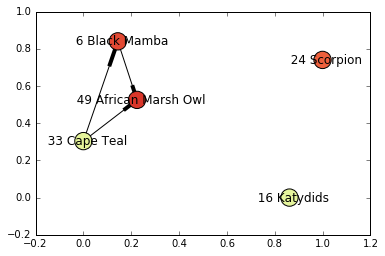

In [2]:
def random_subgraph(graph, N):
    nodes = random.sample(graph.nodes(), N)
    return graph.subgraph(nodes)

subweb = random_subgraph(serengeti, 5)
draw_food_web(subweb)


# Random connected subgraph

Generate a random connected subgraph of G by choosing a node at random, and iteratively adding neighbors to the subgraph until N nodes have been added. This produces some potentially viable food webs, but doesn't guarantee adequate representation of all trophic levels (crucially, basal species aren't always included).

,name,organism_type,cost,description,category,biomass,diet_type,carrying_capacity,metabolism,trophic_level,growth_rate,model_id,unlock,node_id
species_id,,,,,,,,,,,,,,
38,Dwarf Sand Snake,0,50,"The Dwarf Sand Snake is a very small, slender ...",Small Animal,0.0850,1,0,0.018125,3.79062,0,19,2,38
44,Rufous Beaked Snake,0,25,The Rufous Beaked Snake is a species of colubr...,Small Animal,0.0280,1,0,0.023925,3.50856,0,46,3,44
64,Nile Monitor Lizard,0,50,"The Nile Monitor, Water Leguaan, or River Legu...",Small Animal,10.4000,1,0,0.005450,3.48947,0,36,5,64
31,Tree Mouse,0,50,"Tree Mouse, Prionomys batesi, is a poorly unde...",Small Animal,0.0075,0,0,0.795271,2.38095,0,53,1,31
89,Decaying Material,0,20,Decaying Materials are great sources of food f...,Resource,1000.0000,0,10000,0.500000,1.00000,1,999,1,1


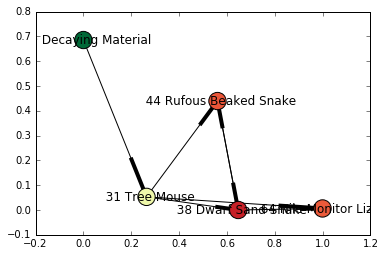

In [3]:
def random_connected_subgraph(G, N, seed_nodes=None, retry=1):
    """seed_nodes: list of nodes from which to randomly choose a starting node"""
    
    if seed_nodes is None:
        seed_nodes = G.nodes()
    nodes = set([random.choice(seed_nodes)])
    
    for i in range(N-1):
        
        # Find the neighbor nodes of the subgraph nodes
        neighbors = set()
        for node in nodes:
            neighbors = neighbors | set(G.predecessors(node) + G.successors(node))
        neighbors = neighbors - nodes # Exclude nodes already in the subgraph
        
        if len(neighbors) == 0:
            print("random_connected_subgraph: no candidate neighbors found. ", end='')
            if (retry > 0):
                print("Retrying.")
                return random_connected_subgraph(G, N, seed_nodes, retry - 1)
            else:
                print("Giving up.")
                return None

        # Add a random neighbor to the subgraph
        nodes.add(random.choice(list(neighbors)))
    
    return G.subgraph(list(nodes))

subweb = random_connected_subgraph(serengeti, 5)

draw_food_web(subweb)
show_species_table([int(species_id) for species_id in subweb.nodes()])

# Random successor subgraph

Generate a random connected subgraph of the given graph. On each iteration, choose only successors to nodes currently in the subgraph.

random_successor_subgraph: 3 connected components. Retrying.
[27, 66, 51, 52, 53, 7, 1001, 1003, 1005, 14]


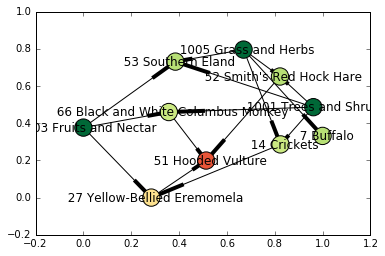

In [4]:
def random_successor_subgraph(G, N, seed_nodes=None, seed_size=1, retry=1):
    """seed_nodes: list of nodes from which to randomly choose seed_size starting nodes"""
    
    if seed_nodes is None:
        seed_nodes = G.nodes()
    nodes = set(random.sample(seed_nodes, seed_size))
    
    for i in range(N - seed_size):
        
        # Find the neighbor nodes of the subgraph nodes
        neighbors = set()
        for node in nodes:
            neighbors = neighbors | set(G.successors(node))
        neighbors = neighbors - nodes # Exclude nodes already in the subgraph
        
        if len(neighbors) == 0:
            print("random_successor_subgraph: no candidate neighbors found. ", end='')
            if (retry > 0):
                print("Retrying.")
                return random_successor_subgraph(G, N, seed_nodes, seed_size=seed_size,
                                                 retry=retry-1)
            else:
                print("Giving up.")
                return None

        # Add a random neighbor to the subgraph
        nodes.add(random.choice(list(neighbors)))
    
    subgraph = G.subgraph(list(nodes))
    num_components = nx.number_connected_components(subgraph.to_undirected())
    if num_components > 1:
        print("random_successor_subgraph: {} connected components. ".format(num_components),
              end='')
        if (retry > 0):
            print("Retrying.")
            return random_successor_subgraph(G, N, seed_nodes, seed_size=seed_size,
                                             retry=retry-1)
        else:
            print("Giving up.")
            return None
    
    return subgraph

# For the seed nodes, use the basal species excluding Decaying Material (89)
seed_nodes = get_basal_species(serengeti)
if 89 in seed_nodes:
    seed_nodes.remove(89)
    
subweb = random_successor_subgraph(serengeti, 10, seed_nodes=seed_nodes, seed_size=3, retry=3)

draw_food_web(subweb)
print(str(subweb.nodes()))

# Finding all simple paths (food chains) from a basal species

[[0, 2]]


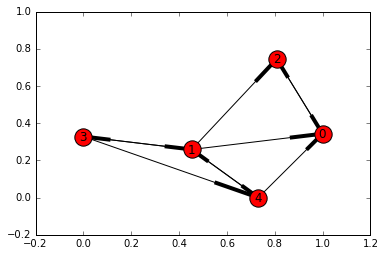

In [5]:
def all_simple_paths_from(graph, source, visited=set()):
    paths = []
    for successor in graph.successors(source):
        if successor not in visited and successor != source:
            paths.append([source, successor])
            for successor_path in all_simple_paths_from(graph, successor, visited | set([source])):
                paths.append([source] + successor_path)
    return paths

# Visual testing
graph = nx.fast_gnp_random_graph(5, 0.25, directed=True)
nx.draw_networkx(graph)
print(all_simple_paths_from(graph, 0))

# Simple cycles

[[0], [2, 3]]


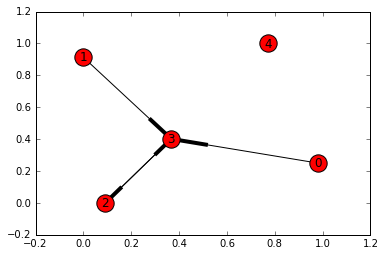

In [6]:
graph = nx.fast_gnp_random_graph(5, 0.25, directed=True)

# Add a self-loop to node 0. We want to exclude self-loops from food chain loops.
graph.add_edge(0, 0)
# It ends up being counted as a simple cycle. Can simply exclude cycles with length 1.

nx.draw_networkx(graph)

print(list(nx.simple_cycles(graph)))

# Adding nodes to subgraphs along with edges

{'something': 'hello', 'else': 'world'}


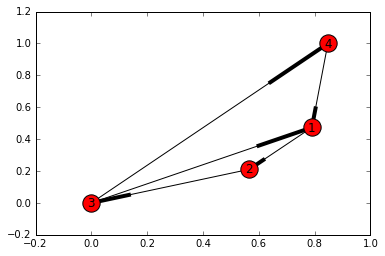

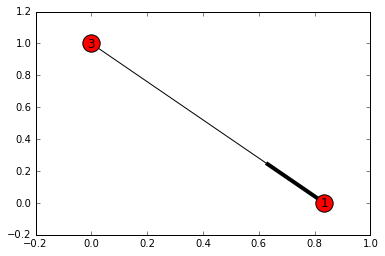

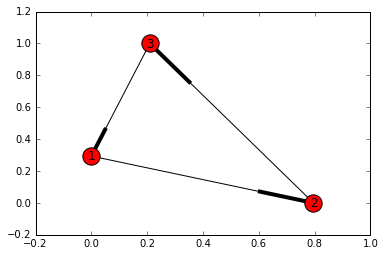

In [7]:
g = nx.DiGraph()
g.add_node(3, {'something': 'hello', 'else': 'world'})
g.add_edge(1,2)
g.add_edge(2,3)
g.add_edge(3,4)
g.add_edge(4,1)
g.add_edge(3,1)
plt.figure()
nx.draw_networkx(g)

def add_node_with_edges(graph, subgraph, node):
    """Add a node from a directed graph to a subgraph of it, along with all edges from the original graph
    that are adjacent to that node and another node existing in the subgraph.
    """
    subgraph.add_node(node)
    for edge in graph.out_edges_iter(node):
        if subgraph.has_node(edge[1]):
            subgraph.add_edge(*edge)
    for edge in graph.in_edges_iter(node):
        if subgraph.has_node(edge[0]):
            subgraph.add_edge(*edge)

plt.figure()
h = g.subgraph([1, 3])
nx.draw_networkx(h)
plt.figure()
add_node_with_edges(g, h, 2)
#add_node_with_edges(g, h, 3)
#add_node_with_edges(g, h, 4)
nx.draw_networkx(h)

# Demonstrate how to copy the attributes of a node from one graph to another
h.node[3] = g.node[3]
print(h.node[3])

# Completing food chains of a graph

The most important constraint of a food web is that there are no incomplete food chains. This function takes a graph and returns a new graph in which all food chains are completed by adding nodes, if necessary.

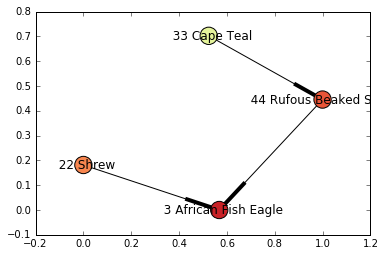

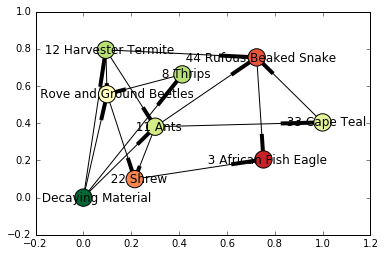

In [8]:
def get_source_nodes(graph, allow_selfloops=True):
    """Get the source nodes (nodes with no in-edges) of the given graph.
    If allow_selfloops is True, a node whose only in-edge is a self-loop is also considered a source node.
    """
    source_nodes = []
    for node, in_degree in graph.in_degree_iter():
        if in_degree == 0:
            source_nodes.append(node)
    if allow_selfloops:
        for node, in_degree in graph.in_degree_iter(graph.nodes_with_selfloops()):
            if in_degree == 1:
                source_nodes.append(node)
    return source_nodes

def complete_food_chains(full_graph, subgraph):
    
    # Make a copy of the subgraph to modify and return
    subgraph2 = subgraph.copy()
    
    # Get the source nodes in the subgraph which are consumers (non-plants).
    # The goal is to have none of these, at which point all food chains will be complete.
    consumer_source_nodes = []
    source_nodes = get_source_nodes(subgraph2)
    for node in source_nodes:
        if float(subgraph2.node[node]['trophic_level']) > 1:
            consumer_source_nodes.append(node)
    
    # Add predecessors to consumer source nodes until there are no consumer source nodes left.
    while len(consumer_source_nodes) > 0:
        
        # Choose a random consumer source node
        consumer_node = random.choice(consumer_source_nodes)
        consumer_source_nodes.remove(consumer_node)
        
        # Add a random predecessor and associated edges
        new_node = random.choice(full_graph.predecessors(consumer_node))
        add_node_with_edges(full_graph, subgraph2, new_node)
        subgraph2.node[new_node] = full_graph.node[new_node] # Copy node attributes
        
        # If the new node is also a consumer source node, add it to the list
        if float(subgraph2.node[new_node]['trophic_level']) > 1:
            consumer_source_nodes.append(new_node)
                
    return subgraph2

subweb = random_connected_subgraph(serengeti, 4)
complete_subweb = complete_food_chains(serengeti, subweb)

draw_food_web(subweb)
plt.figure()
draw_food_web(complete_subweb)

# Predator-complete sub-webs

[49, 50, 30, 71, 1001, 74, 1003, 1005, 55, 47]


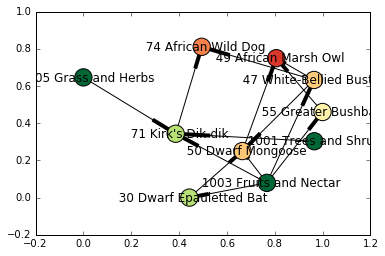

In [9]:
def get_plant_eaters(graph):
    """
    Return the set of nodes which have a source node as a predecessor.
    """
    plant_eaters = set()
    for plant in get_source_nodes(graph):
        for node in graph.successors(plant):
            plant_eaters.add(node)
    return plant_eaters

def predator_complete_subweb(G, N, seed_nodes=None, seed_size=1, retry=1):
    """
    A version of random_successor_subgraph with the following addition:
    Each iteration, before choosing a random neighbor, choose a neighbor of a plant eater
    which does not currently have a predator ("lonely plant eater") in the subgraph (if any).
    
    The goal is to produce a sub-web in which everything that eats plants has a predator,
    but this is not guaranteed, because:
    - Some plant eaters have no predators in the full graph
      (e.g. African Elephant, Hippopotamus)
    - N might be too small to ensure all plant eaters have predators 
    
    seed_nodes: list of nodes from which to randomly choose seed_size starting nodes
    """
    
    if seed_nodes is None:
        seed_nodes = G.nodes()
    nodes = set(random.sample(seed_nodes, seed_size))
    
    plant_eaters = get_plant_eaters(G)
    
    for i in range(N - seed_size):
        
        # Identify any plant eaters without predators
        lonely_plant_eaters = {}  # key: plant eater node; value: list of predator nodes
        # For each plant eater in the current subgraph
        for node in plant_eaters & nodes:
            predators = G.successors(node)
            if node in predators:
                predators.remove(node)  # don't count self as predator (cannibals)
            if len(predators) == 0:
                print("Lonely plant eater {} has no predators in full graph".format(node))
            # If the current subgraph does not contain any of the plant eater's successors
            elif len(nodes & set(predators)) == 0:
                lonely_plant_eaters[node] = predators
        
        # If there are any lonely plant eaters, add a random predator of of any of them
        # and skip to the next iteration of the loop.
        if len(lonely_plant_eaters) > 0:
            candidate_predators = []
            for node, predators in lonely_plant_eaters.items():
                candidate_predators.extend(predators)
            if len(candidate_predators) > 0:
                nodes.add(random.choice(candidate_predators))
                continue
        
        # Find the neighbor nodes of the subgraph nodes
        neighbors = set()
        for node in nodes:
            neighbors = neighbors | set(G.successors(node))
        neighbors = neighbors - nodes # Exclude nodes already in the subgraph
        
        if len(neighbors) == 0:
            print("predator_complete_subweb: no candidate neighbors found. ", end='')
            if (retry > 0):
                print("Retrying.")
                return predator_complete_subweb(G, N, seed_nodes, seed_size=seed_size,
                                                 retry=retry-1)
            else:
                print("Giving up.")
                return None

        # Add a random neighbor to the subgraph
        nodes.add(random.choice(list(neighbors)))
    
    subgraph = G.subgraph(list(nodes))
    num_components = nx.number_connected_components(subgraph.to_undirected())
    if num_components > 1:
        print("random_successor_subgraph: {} connected components. ".format(num_components),
              end='')
        if (retry > 0):
            print("Retrying.")
            return predator_complete_subweb(G, N, seed_nodes, seed_size=seed_size,
                                             retry=retry-1)
        else:
            print("Giving up.")
            return None
    
    return subgraph

# For the seed nodes, use the basal species excluding Decaying Material (89)
seed_nodes = get_basal_species(serengeti)
if 89 in seed_nodes:
    seed_nodes.remove(89)
    
subweb = predator_complete_subweb(serengeti, 10, seed_nodes=seed_nodes, seed_size=3, retry=3)

draw_food_web(subweb)
print(str(subweb.nodes()))

# Swapping in trophically equivalent species

Original: [49, 66, 80, 87, 1001]
orig_node = 1001
pred = {66, 87}
prey = set()
candidate = 1005
pred_of_candidate = {87}
prey_of_candidate = set()
candidate = 21
pred_of_candidate = {66}
prey_of_candidate = set()
candidate = 89
pred_of_candidate = {66}
prey_of_candidate = set()
candidate = 1003
pred_of_candidate = {66}
prey_of_candidate = set()
orig_node = 80
pred = set()
prey = {66, 87}
candidate = 6
pred_of_candidate = {49}
prey_of_candidate = {66}
candidate = 74
pred_of_candidate = set()
prey_of_candidate = {87}
candidate = 49
pred_of_candidate = set()
prey_of_candidate = {66}
candidate = 51
pred_of_candidate = set()
prey_of_candidate = {66}
orig_node = 66
pred = {80, 49}
prey = {1001}
candidate = 4
pred_of_candidate = {49}
prey_of_candidate = set()
candidate = 6
pred_of_candidate = {49}
prey_of_candidate = {66}
candidate = 11
pred_of_candidate = set()
prey_of_candidate = {1001}
candidate = 20
pred_of_candidate = {80}
prey_of_candidate = set()
candidate = 22
pred_of_candidate = {49}

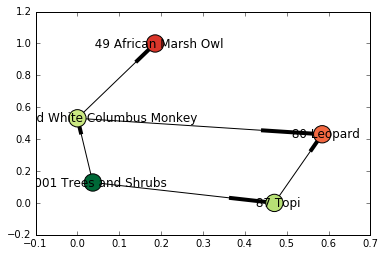

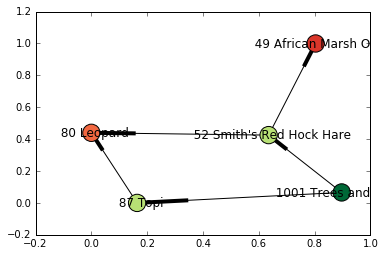

In [58]:
import copy

def swap_species(full, sub):
    """
    Attempt to swap a species in a food sub-web with a trophically equivalent species.
    
    "Trophically equivalent" is defined here as having exactly the same predators and prey
    within the sub-web.
    
    Parameters
    ----------
    full : DiGraph
        The full food web from which to choose a trophically equivalent species.
    sub : DiGraph
        The sub-web.
        
    Returns
    -------
    DiGraph
        The new sub-web with species swapped, or None if no swap was possible.
    """
    
    orig_node = None
    new_node = None
    
    # Iterate through subweb nodes in random order, trying to find one that can be replaced
    for node in random.sample(sub.nodes(), len(sub)):
        orig_node = node
        pred = set(sub.successors(node))
        prey = set(sub.predecessors(node))
        orig_is_cannibal = orig_node in pred
        
        # Find a species in the full graph with the same predators and prey
        
        # Start with candidate species sharing any predators or prey
        new_node_candidates = set()
        for prey_node in prey:
            new_node_candidates |= set(full.successors(prey_node))
        for pred_node in pred:
            new_node_candidates |= set(full.predecessors(pred_node))
        new_node_candidates -= {node}
            
        for candidate in new_node_candidates:
            
            # Original and new node must either be both cannibals or both non-cannibals
            candidate_is_cannibal = full.has_edge(candidate, candidate)
            if candidate_is_cannibal != orig_is_cannibal:
                continue
            
            # If the candidate shares the same predators and prey in the subweb,
            # we've found the species to swap in
            pred_of_candidate = set(full.successors(candidate)) & set(sub.nodes())
            prey_of_candidate = set(full.predecessors(candidate)) & set(sub.nodes())
            if (pred_of_candidate == pred and prey_of_candidate == prey):
                new_node = candidate
                break
                
        if new_node is not None:
            break
    
    if new_node is None:
        print("Could not find a trophically equivalent species.")
        return None
    
    print("Substituted {} for {}".format(new_node, orig_node))
    
    new_sub = full.subgraph(set(sub.nodes()) - {orig_node} | {new_node})
    return new_sub

seed_nodes = get_basal_species(serengeti)
if 89 in seed_nodes:
    seed_nodes.remove(89)
    
subweb = predator_complete_subweb(serengeti, 5, seed_nodes=seed_nodes, seed_size=1, retry=3)

draw_food_web(subweb)
print("Original: " + str(sorted(subweb.nodes())))

subweb2 = swap_species(serengeti, subweb)
if subweb2 is not None:
    print("New:      " + str(sorted(subweb2.nodes())))
    draw_food_web(subweb2)

# Structural properties of food webs

Williams & Martinez 2000 define 12 properties of the network structure of food webs.

Properties
------------------
species_count   10.0000
link_count      19.0000
connectance     0.1900
frac_top_pred   0.2000
frac_intermed   0.6000
frac_basal      0.2000
GenSD           0.8020
VulSD           0.7627
MxSim           0.3974
ChnLg           3.4833
ChnSD           1.2002
ChnNo           1.7782
Cannib          0.1000
Loop            0.0000
Omniv           0.6000


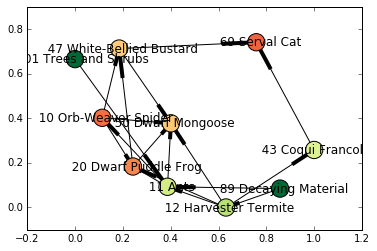

In [10]:
def get_food_chains(graph):
    """
    Return all food chains in the graph, as a list of lists of nodes.
    A food chain is defined here as a simple path from a source node
    (a node with no predecessors) to another node.
    NOTE: The source node is not required to be a basal species.
    """
    food_chains = []
    for source in get_source_nodes(graph):
        food_chains += all_simple_paths_from(graph, source)
    return food_chains

def get_loops(graph):
    """
    Return a list of all simple cycles in the graph with more than one node.
    """
    return [cycle for cycle in nx.simple_cycles(graph) if len(cycle) > 1]

def food_web_properties(graph):
    
    species_count = graph.number_of_nodes()
    link_count = graph.size() # Yes, graph.size() is the number of edges
    
    consumers_without_prey = []
    
    top_predator_count = 0
    intermediate_species_count = 0
    basal_species_count = 0
    generality = [None] * species_count
    vulnerability = [None] * species_count
    max_similarity = [None] * species_count
    
    food_chains = get_food_chains(graph)                  
    #print("Food chains: {}\n".format(food_chains))
    food_chain_lengths = [len(chain) - 1 for chain in food_chains] # subtract 1 to count edges
    
    loops = get_loops(graph)
    species_in_loops = set()
    for loop in loops:
        species_in_loops |= set(loop)
    #print("Loops: {}\n".format(loops))
    #print("Species in loops: {}\n".format(species_in_loops))
    
    # Species with multiple prey and food chains of different lengths
    omnivores = []
    # Food chains indexed by ID of the species at the top
    food_chains_by_species = {}
    for chain in food_chains:
        species_id = chain[-1]
        if species_id not in food_chains_by_species:
            food_chains_by_species[species_id] = []
        food_chains_by_species[chain[-1]].append(chain)
    #print("Food chains by species: {}".format(food_chains_by_species))
    
    for i, (species_id, species_attributes) in enumerate(graph.nodes(data=True)):
        predators = graph.successors(species_id)
        prey = graph.predecessors(species_id)
        trophic_level = float(species_attributes['trophic_level'])
        
        if trophic_level > 1 and (len(prey) == 0 or
                                  # Cannibal with no other prey in the subweb:
                                  (len(prey) == 1 and prey[0] == species_id)):
            consumers_without_prey.append(species_id)
        
        # Identify top predators by their position in this sub-web
        if (len(predators) == 0 or
                # Allow for cannibalism in top predators
                (len(predators) == 1 and predators[0] == species_id)):
            top_predator_count += 1
            
        # Identify basal species by trophic level in the full Serengeti food web
        elif trophic_level == 1:
            basal_species_count += 1
            
        # Count all other species as intermediate
        else:
            intermediate_species_count += 1
            
        generality[i] = len(prey) / (link_count / species_count)
        vulnerability[i] = len(predators) / (link_count / species_count)
        
        # Trophic similarity of a pair of species (s[i,j]) is the number of
        # predators and prey shared in common divided by the pair's total
        # number of predators and prey. (Williams & Martinez 2000)
        # FIXME: This could probably be much more efficient with matrices
        trophic_similarity = [None] * species_count
        for j, j_species_id in enumerate(graph.nodes()):
            if j == i:
                trophic_similarity[j] = 0
                continue
            j_predators = graph.successors(j_species_id)
            j_prey = graph.predecessors(j_species_id)
            shared_predators = set(predators) & set(j_predators)
            shared_prey = set(prey) & set(j_prey)
            total_predators = set(predators + j_predators)
            total_prey = set(prey + j_prey)
            
            # TODO: Is this interpretation correct?
            shared_count = len(shared_predators) + len(shared_prey)
            total_count = len(total_predators)  + len(total_prey)
            if total_count == 0:
                trophic_similarity[j] = 0.0
            else:
                trophic_similarity[j] = shared_count / total_count
   
        max_similarity[i] = max(trophic_similarity)
    
        # Omnivory
        if len(prey) > 1:
                             # subtract 1 to count edges
            chain_lengths = [len(chain) - 1 for chain in food_chains_by_species.get(species_id, [])]
            if len(set(chain_lengths)) > 1:
                omnivores.append(species_id)
    
    #print("Omnivores: {}".format(omnivores))
    
    #print("Consumers without prey: {}".format(consumers_without_prey))
            
    props = OrderedDict()
    props['species_count'] = species_count
    props['link_count'] = link_count
    props['connectance'] = link_count / species_count ** 2
    props['frac_top_pred'] = top_predator_count / species_count
    props['frac_intermed'] = intermediate_species_count / species_count
    props['frac_basal'] = basal_species_count / species_count
    props['GenSD'] = stdev(generality)
    props['VulSD'] = stdev(vulnerability)
    props['MxSim'] = sum(max_similarity) / species_count
    props['ChnLg'] = mean(food_chain_lengths)
    props['ChnSD'] = stdev(food_chain_lengths)
    props['ChnNo'] = log10(len(food_chains))
    props['Cannib'] = graph.number_of_selfloops() / species_count
    props['Loop'] = len(species_in_loops) / species_count
    props['Omniv'] = len(omnivores) / species_count
    #props['food_chains'] = sorted(food_chains, key=len, reverse=True)
    
    return props

def print_food_web_properties(properties):
    print("Properties\n------------------")
    for k, v in properties.items():
        if isinstance(v, float) or isinstance(v, int):
            print("{:15s} {:.4f}".format(k, v))
        elif k == 'food_chains':
            print("{:15s} Food chains:")
            if len(v) > 20:
                print("More than 20")
            else:
                for chain in v:
                    print("{:15s} {}".format('', chain))

basal_species = get_basal_species(serengeti)
#subweb = random_connected_subgraph(serengeti, 6, basal_species, retry=3)
#subweb = random_successor_subgraph(serengeti, 6, basal_species, retry=3)
subweb = complete_food_chains(serengeti, random_connected_subgraph(serengeti, 6))
draw_food_web(subweb)

properties = food_web_properties(subweb)
print_food_web_properties(properties)

# Properties of full Serengeti food web

In [11]:
#print("ORIGINAL SERENGETI FOOD WEB")
#print_food_web_properties(food_web_properties(serengeti_orig))
#print()
print("PRUNED SERENGETI FOOD WEB")
serengeti_properties = food_web_properties(serengeti)
print_food_web_properties(serengeti_properties)

PRUNED SERENGETI FOOD WEB
Properties
------------------
species_count   87.0000
link_count      538.0000
connectance     0.0711
frac_top_pred   0.2184
frac_intermed   0.7126
frac_basal      0.0690
GenSD           0.8989
VulSD           1.1828
MxSim           0.4502
ChnLg           6.5461
ChnSD           1.7752
ChnNo           4.8983
Cannib          0.1379
Loop            0.0460
Omniv           0.6437


## Components

Number of components: 1
Sizes: [87]


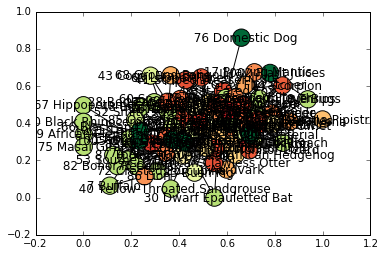

In [12]:
serengeti_u = serengeti.to_undirected()
components = list(nx.connected_component_subgraphs(serengeti_u))
print("Number of components: {}".format(len(components)))
print("Sizes: {}".format([g.number_of_nodes() for g in components]))

for component in components:
    plt.figure()
    draw_food_web(component)
    
# Originally, this revealed 11 isolated species, now removed in the first cell of code

# Generate and compare food sub-webs, compare to Serengeti

## Generate and save the data

In [13]:
foodweb_count = 1001
df = pd.DataFrame(index=np.arange(foodweb_count), columns=['species_list'] + list(serengeti_properties.keys()))
df.loc[0] = serengeti_properties
for i in range(1, foodweb_count):
    desired_species_count = random.randint(3, 86)
    subweb = complete_food_chains(serengeti, random_connected_subgraph(serengeti, desired_species_count))
    data = food_web_properties(subweb)
    data['species_list'] = ' '.join([str(i) for i in sorted(subweb.nodes())])
    df.loc[i] = data
    
df.to_csv('food-webs-{}.csv'.format(foodweb_count))

## Plot properties

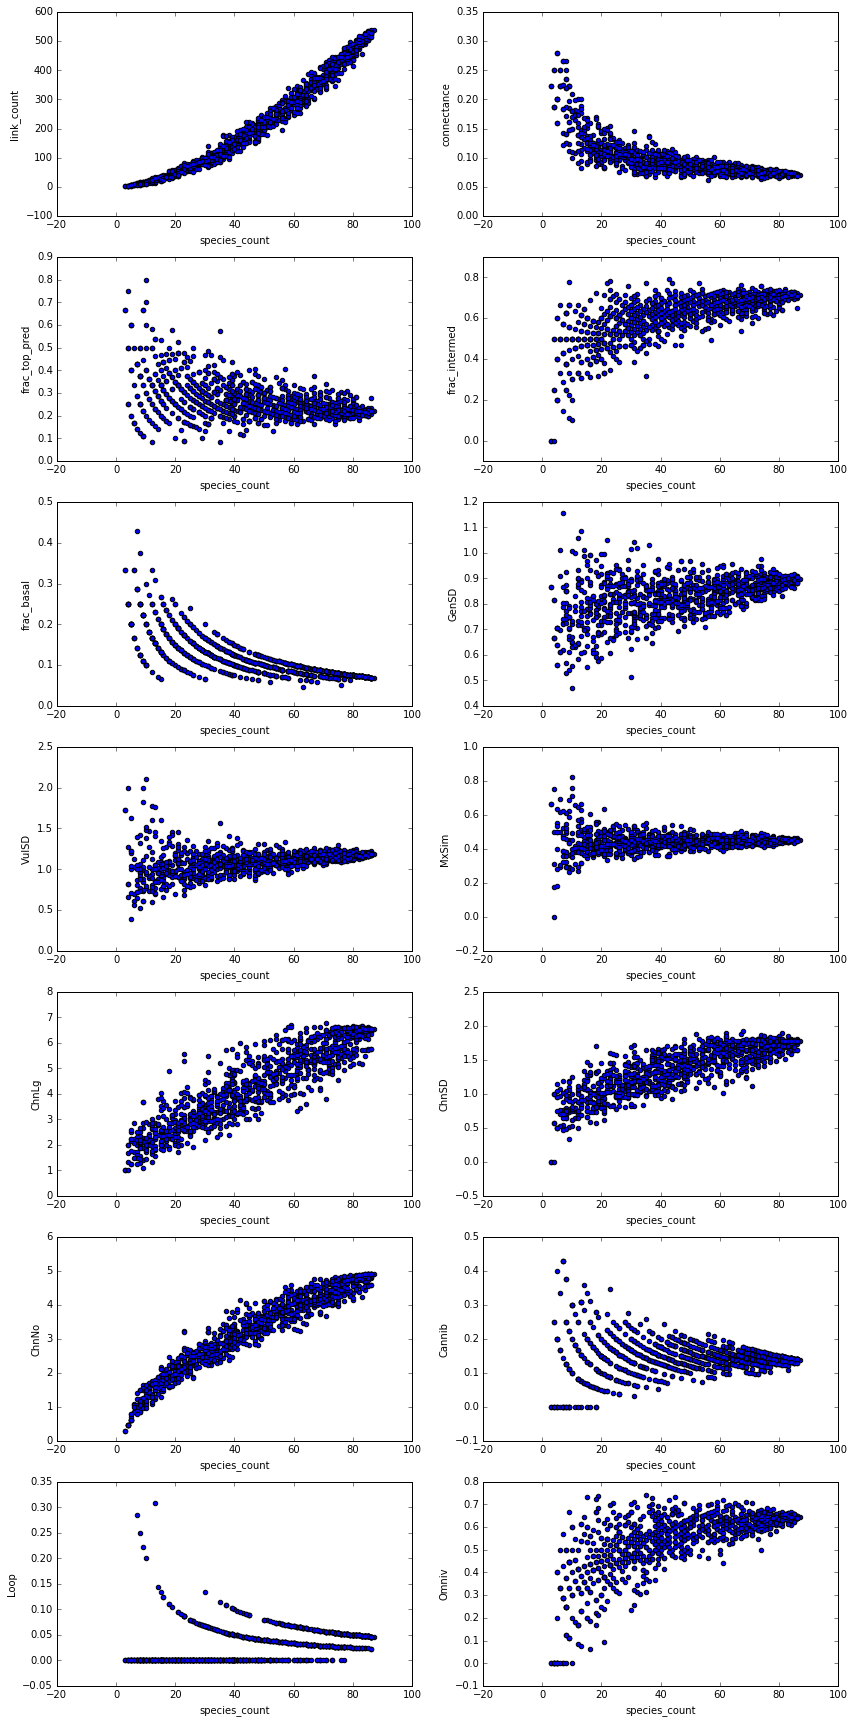

In [14]:
properties_to_plot = [
    'link_count',
    'connectance',
    'frac_top_pred',
    'frac_intermed',
    'frac_basal',
    'GenSD',
    'VulSD',
    'MxSim',
    'ChnLg',
    'ChnSD',
    'ChnNo',
    'Cannib',
    'Loop',
    'Omniv',
]

fig, axes = plt.subplots(nrows=math.ceil(len(properties_to_plot)/2), ncols=2)

for i, prop in enumerate(properties_to_plot):
    df.plot.scatter('species_count', prop, ax=axes[i // 2, i % 2], figsize=(14,30))

Pick some

In [15]:
df7 = df.loc[df['species_count'] == 7]
#df7 = df.query('species_count == 7 and frac_intermed > 2 * frac_top_pred')
display(df.iloc[0])
df7 = df7.assign(ratio_top_intermed = df7['frac_top_pred'] / df7['frac_intermed'])
df7 = df7.loc[df7['ratio_top_intermed'] <= 0.5]
display(df7)
df7.describe()

species_list           NaN
species_count           87
link_count             538
connectance      0.0710794
frac_top_pred     0.218391
frac_intermed     0.712644
frac_basal       0.0689655
GenSD             0.898852
VulSD              1.18281
MxSim             0.450244
ChnLg              6.54612
ChnSD              1.77516
ChnNo              4.89833
Cannib            0.137931
Loop              0.045977
Omniv             0.643678
Name: 0, dtype: object

,species_list,species_count,link_count,connectance,frac_top_pred,frac_intermed,frac_basal,GenSD,VulSD,MxSim,ChnLg,ChnSD,ChnNo,Cannib,Loop,Omniv,ratio_top_intermed
538,9 13 16 20 64 89 1003,7,13,0.265306,0.142857,0.571429,0.285714,0.724331,0.654223,0.476701,2.30769,0.884047,1.41497,0.142857,0,0.571429,0.25
658,9 20 22 38 44 83 89,7,11,0.22449,0.285714,0.571429,0.142857,0.721569,0.721569,0.461905,2.5,1.19523,0.90309,0.428571,0.285714,0.285714,0.5
753,6 9 13 32 37 89 1003,7,13,0.265306,0.142857,0.571429,0.285714,0.788227,0.724331,0.388605,2.17647,1.0146,1.23045,0.428571,0,0.428571,0.25


,species_list,species_count,link_count,connectance,frac_top_pred,frac_intermed,frac_basal,GenSD,VulSD,MxSim,ChnLg,ChnSD,ChnNo,Cannib,Loop,Omniv,ratio_top_intermed
count,3,3,3,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.0,3.000000,3.00
unique,3,1,2,2.000000,2.000000,1.000000,2.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,2.000000,2.0,3.000000,2.00
top,9 13 16 20 64 89 1003,7,13,0.265306,0.142857,0.571429,0.285714,0.788227,0.724331,0.388605,2.5,1.014599,1.230449,0.428571,0.0,0.428571,0.25
freq,1,3,2,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,2.000000,2.0,1.000000,2.00


# Calculating trophic levels

Root mean squared error: 0.3778980513309973
Bias (mean error): 0.2169967996059378


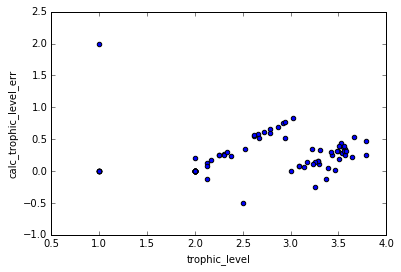

In [16]:
def calc_trophic_level(node, graph, visited=set()):
    species = graph.node[node]
    if 'calc_trophic_level' in species:
        return species['calc_trophic_level']  # Return memoized value
    
    # Track the nodes visited along this path to avoid getting stuck in trophic loops
    visited = visited | {node}
    
    prey = set(graph.predecessors(node)) - visited
    if len(prey) == 0:
        level = 1  # basal species
    else:
        level = 1 + mean([calc_trophic_level(n, graph, visited) for n in prey])
    species['calc_trophic_level'] = level  # Memoize
    return level

def get_top_predators(graph):
    top = []
    for node, out_degree in graph.out_degree_iter():
        if out_degree == 0 or (
                # Top predator with cannibalism
                out_degree == 1 and graph.successors(node)[0] == node):
            top.append(node)
    return top

for node in get_top_predators(serengeti):
    calc_trophic_level(node, serengeti)

species_table['calc_trophic_level'] = None
for node, species in serengeti.nodes_iter(data=True):
    species_table.set_value(node, 'calc_trophic_level', species['calc_trophic_level'])
species_table['calc_trophic_level_err'] = species_table['calc_trophic_level'] - species_table['trophic_level']
species_table['calc_trophic_level_err2'] = species_table['calc_trophic_level_err'] ** 2
rmse = math.sqrt(species_table['calc_trophic_level_err2'].mean())
print("Root mean squared error: {}".format(rmse))
print("Bias (mean error): {}".format(species_table['calc_trophic_level_err'].mean()))
species_table.plot.scatter('trophic_level', 'calc_trophic_level_err')

In [17]:
species_table.loc[:, ('name', 'trophic_level', 'calc_trophic_level', 'calc_trophic_level_err2')].to_csv('calc_trophic_level.csv')

# Topological sort

This puts prey before predators. Hoped it would fix bad ATNEngine behavior, but it doesn't.

In [18]:
subgraph_nodes = map(int, '64 16 26 69 87 1001 42 1003 45 31'.split())
g = serengeti.subgraph(subgraph_nodes)
g.remove_edges_from(g.selfloop_edges())
sorted_nodes = nx.topological_sort(g)
print(' '.join(map(str, sorted_nodes)))
print("\nTrophic levels:")
for node in sorted_nodes:
    print(serengeti.node[node]['trophic_level'])


1003 1001 31 45 87 69 16 26 42 64

Trophic levels:
1
1
2.38095
2.8657
2
3.43754
2.30357
2.65786
2.66657
3.48947


# Replacing a species in an existing sub-web

[42, 31, 1005, 14, 63]


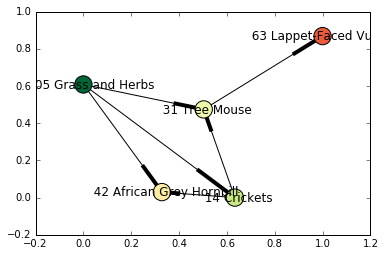

In [19]:
# Convergence ecosystem 0
orig_nodes = [1005, 14, 31, 42, 2]
#orig_subweb = serengeti.subgraph(orig_nodes)
#draw_food_web(orig_subweb)

orig_nodes.remove(2)
new_subweb = random_successor_subgraph(serengeti, 5, orig_nodes, 4)
print(new_subweb.nodes())
draw_food_web(new_subweb)

# Scratch

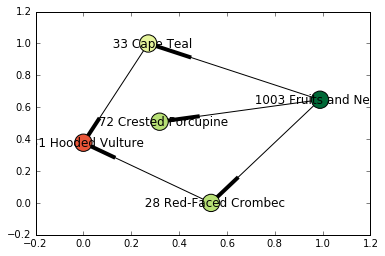

In [20]:
# Set 44
subweb = serengeti.subgraph([int(i) for i in '72 33 1003 28 51'.split()])
draw_food_web(subweb)